In [205]:
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
from queue import PriorityQueue

In [175]:
env = gym.make('MountainCar-v0')

In [217]:
q = PriorityQueue()
q.put((1, 'olle'))
print(q.empty())
print(q.get())
print(q.empty())

False
(1, 'olle')
True


In [339]:
class QAgent:
    def __init__(self, env):
        self.epsilon = 0.05
        self.epsilon_max = 0.05
        self.epsilon_min = 0.05
        self.epsilon_decay = (self.epsilon_max - self.epsilon_min) / 1000
        self.discount_factor = 0.95
        self.learning_rate = 0.1
        self.state_size = len(env.observation_space.high)
        self.action_size = env.action_space.n
        self.discrete_table_size = 20
        self.q_table = self.build_q_table()
        self.model = {}
        self.prio_q = PriorityQueue()
        self.priority_threshold = 0.000001
    
    def build_q_table(self):
        table_size = [self.discrete_table_size] * self.state_size
        q_table = np.random.uniform(low=-2, high=0, size=(table_size+[self.action_size]))
        return q_table
    
    def get_discrete_state(self, state):
        normalized_state = (state - env.observation_space.low) / (env.observation_space.high - env.observation_space.low)
        rescaled_state = normalized_state * self.discrete_table_size
        return tuple(rescaled_state.astype(np.int))
    
    def get_cont_state(self, state):
        normalized_state = np.array([float(state[0]), float(state[0])]) / self.discrete_table_size
        return normalized_state * (env.observation_space.high - env.observation_space.low) + env.observation_space.low
    
    def act(self, state):
        if self.epsilon_max >= self.epsilon >= self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        discrete_state = self.get_discrete_state(state)
        if np.random.random() > self.epsilon:
            q_values = self.q_table[discrete_state]
            return np.argmax(q_values)
        else:
            return np.random.choice(np.arange(self.action_size))
          
    def update(self, state, action, reward, next_state, done):
        if not type(state[0]) == np.int64:
            disc_already_done = False
            discrete_state = self.get_discrete_state(state)
            discrete_next_state = self.get_discrete_state(next_state)
        else:
            disc_already_done = True
            discrete_state = tuple((state[0], state[1]))
            discrete_next_state = tuple((next_state[0], next_state[1]))
        
        if not disc_already_done and next_state[0] >= env.goal_position:
            self.q_table[discrete_state][action] = 0
        elif disc_already_done and self.get_cont_state(next_state)[0] >= env.goal_position:
            self.q_table[discrete_state][action] = 0
        else:
            best_next_q_value = np.max(self.q_table[discrete_next_state])
            target = reward + self.discount_factor * best_next_q_value
            self.q_table[discrete_state][action] += self.learning_rate * (target - self.q_table[discrete_state][action])
    
    
    def update_model(self, state, action, reward, next_state):
        self.model[(tuple(self.get_discrete_state(state)), action)] = (reward, self.get_discrete_state(next_state))
        
    def uptate_prio_q(self, state, action, reward, next_state):
        if not type(state[0]) == np.int64:
            discrete_state = self.get_discrete_state(state)
            discrete_next_state = self.get_discrete_state(next_state)
        else:
            discrete_state = state
            discrete_next_state = next_state
        prio = reward + self.discount_factor * np.max(self.q_table[discrete_next_state]) - self.q_table[discrete_state][action]
        if abs(prio) > self.priority_threshold:
            self.prio_q.put((-prio, (discrete_state, action)))

In [340]:
def find_prior_state_action_pairs(model, discrete_state):
    priors = []
    for (prior_state, prior_action), (reward, next_state) in agent.model.items():
        if next_state == discrete_state:
            priors.append((prior_state, prior_action, reward))
    return priors

In [347]:
num_episodes = 200
agent = QAgent(env)
planning = True

episode_rewards = [0] * num_episodes
for i_episode in range(num_episodes):
    state = env.reset()
    done = False
    if (i_episode+1) % 20 == 0:
        print('\r', i_episode+1, end='')
        sys.stdout.flush()

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        episode_rewards[i_episode] += reward
        agent.update(state, action, reward, next_state, done)
        agent.update_model(state, action, reward, next_state)
        #agent.uptate_prio_q(state, action, reward, next_state)
        if planning:
            for i in range(50):
                #if agent.prio_q.empty():
                #    print(i)
                #    break
                #"""    
                #No priority
                random_idx = np.random.choice(np.arange(len(agent.model.keys())))
                random_state_action_pair = list(agent.model.keys())[random_idx]
                random_state = list(random_state_action_pair[0])
                random_action = random_state_action_pair[1]
                random_reward = agent.model[random_state_action_pair][0]
                random_next_state = agent.model[random_state_action_pair][1]
                agent.update(random_state, random_action, random_reward, random_next_state, False)
                #"""
                # Prioritized sweep
                """
                prio_state, prio_action = agent.prio_q.get()[1]
                prio_reward, prio_next_state = agent.model[(prio_state, prio_action)]
                agent.update(prio_state, prio_action, prio_reward, prio_next_state, done=False)
                priors = find_prior_state_action_pairs(agent.model, prio_state)
                for prior_state, prior_action, reward in priors:
                    agent.uptate_prio_q(prior_state, prior_action, reward, prio_state)
                """
                
        state = next_state
    if episode_rewards[i_episode] > -200:
        print('made it')

 200

In [348]:
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)
X, Y = np.meshgrid(x,y)
Z = np.zeros([20,20])
for i_idx, i in enumerate(X):
    for j_idx, j in enumerate(Y):
        Z[i_idx][j_idx] = -np.max(agent.q_table[i_idx][j_idx])

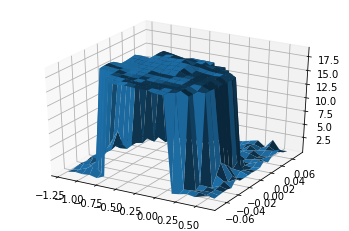

In [349]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

In [62]:
def running_avg(x, window):
    return [np.mean(x[i-min(window,i):i]) for i in range(len(x))]

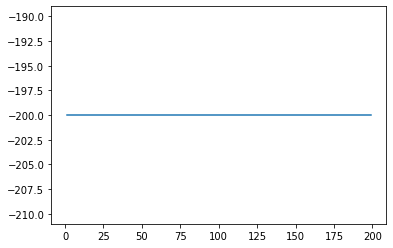

In [350]:
plt.plot(running_avg(episode_rewards, 1))
plt.show()

In [144]:
np.save('DynaQ.npy', episode_rewards)

In [145]:
x = np.load('DynaQ.npy')
x

array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -181., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -162., -191.,
       -169., -152., -198., -200., -155., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -191., -200., -181., -200.,
       -200., -165., -200., -200., -200., -161., -152., -200., -147.,
       -183., -194., -164., -200., -200., -185., -167., -200., -200.,
       -176., -200., -150., -157., -118., -200., -200., -159., -185.,
       -198., -200., -153., -200., -200., -163., -200., -174., -157.,
       -178., -159., -161., -200., -172., -200., -150., -200., -200.,
       -200.])